<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

## Practice Data Format Transformations: "Long" vs. "Wide" Format

_Authors: Kiefer Katovich (SF)_

---

In this lab you will practice going between long and wide formats in pandas, getting deeper into `melt`, `pivot_tables`, and the pitfalls of hierarchical indices than we covered in the lesson.


Recall that **long format** has:

- Potentially multiple "id" (identification) columns.
- Variable:value column pairs that match a variable key to a value (in the simple case, a single variable column and a single value column).
- The "variable" column corresponds to the multiple variable columns in your wide format data. Now, instead of a column for each variable, you have a row for each variable:value pair, per id. 
- This is a standard format in SQL databases because it is appropriate for joining different tables together by keys.

And **wide format:**

- There are multiple ID _and_ value columns. In other words, there is a column for every "variable" with its own unique values.
- The format has both the conceptual simplicity of a single column of values per variable and a more compact matrix.
- Is not useful for SQL-style operations: it can make it much harder or even impossible to join tables together on a value.
- Can be more useful in pandas when you need to preform operations on variables **across columns**. For example, multiplying columns together.
- It is the most commonly the format that you will put the data in when you are ready to perform modeling (with some exceptions). When we get into modeling next week I will explain why.

---

## A: Humor styles dataset

We are going to explore a dataset where people answered a questionnaire on their "humor styles", which tries to get at differences in people's sense of humor and their relationship with humor.

---

### A.1: The 32 questions

Subjects answered **32** different questions outlined below:

1. I usually don't laugh or joke with other people.
2. If I feel depressed, I can cheer myself up with humor.
3. If someone makes a mistake, I will tease them about it.
4. I let people laugh at me or make fun of me at my expense more than I should.
5. I don't have to work very hard to make other people laugh. I am a naturally humorous person.
6. Even when I'm alone, I am often amused by the absurdities of life.
7. People are never offended or hurt by my sense of humor.
8. I will often get carried away in putting myself down if it makes family or friends laugh.
9. I rarely make other people laugh by telling funny stories about myself.
10. If I am feeling upset or unhappy I usually try to think of something funny about the situation to make myself feel better.
11. When telling jokes or saying funny things, I am usually not concerned about how other people are taking it.
12. I often try to make people like or accept me more by saying something funny about my own weaknesses, blunders, or faults.
13. I laugh and joke a lot with my closest friends.
14. My humorous outlook on life keeps me from getting overly upset or depressed about things.
15. I do not like it when people use humor as a way of criticizing or putting someone down.
16. I don't often say funny things to put myself down.
17. I usually don't like to tell jokes or amuse people.
18. If I'm by myself and I'm feeling unhappy, I make an effort to think of something funny to cheer myself up.
19. Sometimes I think of something that is so funny that I can't stop myself from saying it, even if it is not appropriate for the situation.
20. I often go overboard in putting myself down when I am making jokes or trying to be funny.
21. I enjoy making people laugh.
22. If I am feeling sad or upset, I usually lose my sense of humor.
23. I never participate in laughing at others even if all my friends are doing it.
24. When I am with friends or family, I often seem to be the one that other people make fun of or joke about.
25. I donít often joke around with my friends.
26. It is my experience that thinking about some amusing aspect of a situation is often a very effective way of coping with problems.
27. If I don't like someone, I often use humor or teasing to put them down.
28. If I am having problems or feeling unhappy, I often cover it up by joking around, so that even my closest friends don't know how I really feel.
29. I usually can't think of witty things to say when I'm with other people.
30. I don't need to be with other people to feel amused. I can usually find things to laugh about even when I'm by myself.
31. Even if something is really funny to me, I will not laugh or joke about it if someone will be offended.
32. Letting others laugh at me is my way of keeping my friends and family in good spirits.

---

### A.2: Response codes

For each question, there are 5 possible response codes ("likert scale") that correspond to different answers. There is also a code that indicates there is no response for that subject.

    1 == "Never or very rarely true"
    2 == "Rarely true"
    3 == "Sometimes true"
    4 == "Often true"
    5 == "Very often or always true
    [-1 == Did not select an answer]

---

[For more info: https://en.wikipedia.org/wiki/Humor_styles]

---

## B: Load modules

Let's load the standard modules we always use. None of these are new to you.

---

In [1]:
# data modules
import numpy as np
import scipy.stats as stats
import pandas as pd

# plotting modules
import matplotlib.pyplot as plt
import seaborn as sns

# make sure charts appear in the notebook:
%matplotlib inline

---

## C: Loading and examining the data

The dataset is stored in your **```datasets/humor_styles```** directory.

The dataset is called **```hsq_data.csv```**. "hsq", as you might expect, stands for "humor styles questionnaire.

[There is also a file called **```hsq_codebook.txt```** which is a text file that contains the information I detailed above. You can examine it if you like.]

---

### C.1: Create path string and load into pandas

In [2]:
hsq_path = '../datasets/hsq_data.csv'

hsq = pd.read_csv(hsq_path)

---

### C.2 Look at the header.

Let's make sure it looks like what we expect and the data didn't load in incorrectly. This is, of course, always good practice.

In [3]:
hsq.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q30,Q31,Q32,affiliative,selfenhancing,agressive,selfdefeating,age,gender,accuracy
0,2,2,3,1,4,5,4,3,4,3,...,4,2,2,4.0,3.5,3.0,2.3,25,2,100
1,2,3,2,2,4,4,4,3,4,3,...,4,3,1,3.3,3.5,3.3,2.4,44,2,90
2,3,4,3,3,4,4,3,1,2,4,...,5,4,2,3.9,3.9,3.1,2.3,50,1,75
3,3,3,3,4,3,5,4,3,-1,4,...,5,3,3,3.6,4.0,2.9,3.3,30,2,85
4,1,4,2,2,3,5,4,1,4,4,...,5,4,2,4.1,4.1,2.9,2.0,52,1,80


Looking at the head it's apparent we have **32 columns for each question**, but if we scroll over to the right we can see that there are **7 columns of subject properties**.

What are these properties? Some are clear and some are not.

#### Styles of humor:

1. **affiliative**
    - The style of humor used to enhance one's relationships with others in a positive and benevolent way. 
2. **selfenhancing** 
    - The style of humor related to having a good-natured attitude toward life, having the ability to laugh at yourself, your circumstances and the idiosyncrasies of life in constructive, non-detrimental manner.
3. **aggressive** 
    - The style of humor that is potentially detrimental towards others. This type of humor is characterized by the use of sarcasm, put-downs, teasing, criticism, ridicule, and other types of humor used at the expense of others.   
4. **selfdefeating** 
    - The style of humor characterized by the use of potentially detrimental humor towards the self in order to gain approval from others. Individuals high in this dimension engage in self-disparaging humor in which laughter is often at their own expense.
    
These are dimensions of humor calculated from the question responses. 

- The two positive dimensions of humore are: **affiliative** and **selfenhancing**. 
- The two _(purportedly)_ negative dimensions of humor are: **aggressive** and **selfdefeating**.

We are going to calculate these manually later to practice column-wise operations in pandas.

---

#### Demographics and self-reported accuracy

The demographic columns are:

- **age**
- **gender**
    - 1 == male
    - 2 == female
    - 3 == other

Demographics are great to have for each subject in a dataset. We will see the reasons for this later when we start doing regressions and classification.

The **accuracy** column is the self-reported accuracy of the questions by the subjects. It is how accurate they thought their answers were on a scale from 0 to 100.

**If a subject entered 0 for accuracy, this actually means they did not want to be included in research.**

---

### C.3: Data shape

Lets start to take a look at our data. Print out the shape of the DataFrame.

In [4]:
hsq.shape

(1071, 39)

**C.3.1:** What does the shape mean? What does it tell us for this dataset?

**C.3.1.A:** The shape tells us how many rows and columns there are. There  are 1071 rows and 39 columns.

For this dataset we have individuals in rows, so we know that our N=1071.

---

### C.4: Describe the data

**C.4.1** Print out the names of the columns. You can see that aggressive is misspelled "agressive". Replace that column specifically using the ```.rename()``` built-in function. 

In [5]:
print hsq.columns
print hsq['agressive'][1:3]

Index([u'Q1', u'Q2', u'Q3', u'Q4', u'Q5', u'Q6', u'Q7', u'Q8', u'Q9', u'Q10',
       u'Q11', u'Q12', u'Q13', u'Q14', u'Q15', u'Q16', u'Q17', u'Q18', u'Q19',
       u'Q20', u'Q21', u'Q22', u'Q23', u'Q24', u'Q25', u'Q26', u'Q27', u'Q28',
       u'Q29', u'Q30', u'Q31', u'Q32', u'affiliative', u'selfenhancing',
       u'agressive', u'selfdefeating', u'age', u'gender', u'accuracy'],
      dtype='object')
1    3.3
2    3.1
Name: agressive, dtype: float64


In [6]:
hsq.rename(columns={'agressive':'aggressive'}, inplace=True)

**C.4.2** Use the describe built-in function to look at the data

In [7]:
hsq.describe()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q30,Q31,Q32,affiliative,selfenhancing,aggressive,selfdefeating,age,gender,accuracy
count,1071.000000,1071.000000,1071.000000,1071.000000,1071.000000,1071.000000,1071.000000,1071.000000,1071.000000,1071.000000,...,1071.000000,1071.000000,1071.000000,1071.000000,1071.000000,1071.000000,1071.000000,1071.000000,1071.000000,1071.000000
mean,2.025210,3.342670,3.078431,2.833800,3.599440,4.152194,3.277311,2.535014,2.582633,2.869281,...,3.945845,2.767507,2.838469,4.010644,3.375537,2.956583,2.762745,70.966387,1.455649,87.542484
std,1.075782,1.112898,1.167877,1.160252,1.061281,0.979315,1.099974,1.231380,1.224530,1.205013,...,1.135189,1.309601,1.233889,0.708479,0.661533,0.410870,0.645982,1371.989249,0.522076,12.038483
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,1.300000,0.000000,0.000000,0.000000,14.000000,0.000000,2.000000
25%,1.000000,3.000000,2.000000,2.000000,3.000000,4.000000,3.000000,2.000000,2.000000,2.000000,...,3.000000,2.000000,2.000000,3.600000,2.900000,2.800000,2.300000,18.500000,1.000000,80.000000
50%,2.000000,3.000000,3.000000,3.000000,4.000000,4.000000,3.000000,2.000000,2.000000,3.000000,...,4.000000,3.000000,3.000000,4.100000,3.400000,3.000000,2.800000,23.000000,1.000000,90.000000
75%,3.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,3.000000,3.000000,4.000000,...,5.000000,4.000000,4.000000,4.500000,3.800000,3.300000,3.100000,31.000000,2.000000,95.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.100000,5.000000,5.000000,5.000000,44849.000000,3.000000,100.000000


**C.4.3** The maximum age is 44849, which is obviously impossible. Clearly there was at least 1 subject that is incorrectly entering their age.

**C.4.4** Calculate and print just the standard deviation for the columns.

In [8]:
hsq.std()

Q1                  1.075782
Q2                  1.112898
Q3                  1.167877
Q4                  1.160252
Q5                  1.061281
Q6                  0.979315
Q7                  1.099974
Q8                  1.231380
Q9                  1.224530
Q10                 1.205013
Q11                 1.249987
Q12                 1.229589
Q13                 0.884965
Q14                 1.270499
Q15                 1.378185
Q16                 1.214519
Q17                 1.147638
Q18                 1.206461
Q19                 1.258762
Q20                 1.123365
Q21                 0.968822
Q22                 1.241625
Q23                 1.221576
Q24                 1.148647
Q25                 0.885887
Q26                 1.206496
Q27                 1.291101
Q28                 1.318739
Q29                 1.210356
Q30                 1.135189
Q31                 1.309601
Q32                 1.233889
affiliative         0.708479
selfenhancing       0.661533
aggressive    

**C.4.5**

Three examples of potentially bad data in this dataset:

1. Questions have different standard deviations, but we know the range for the questions is restricted. This means that for the questions with **higher standard deviation** there is **more variability of responses**. 
2. The standard deviation for age is 1371, which is higher than any possible age range. This is an example of how outliers screw with a lot of statistical measures.
3. The standard deviation is lower for the humor style columns. People's values for these attributes are closer together, on average (but keep in mind this might just be because the range is "shrunk", which is why it is important to look at both and plot. There are also -1s in the questions that can skew the answers' distributions, as we will see below).

**C.4.6** Using seaborn, plot the distribution for Q15 and plot the distribution for aggressive

[Note: you can set ```sns.set(rc={"figure.figsize": (12, 12)})``` entered before the distribution plot will set the figure size to 12x12 instead of using the `fig = plt.figure(figsize=(12,12))` pattern. Just another way to do the same thing, use whichever you prefer.]

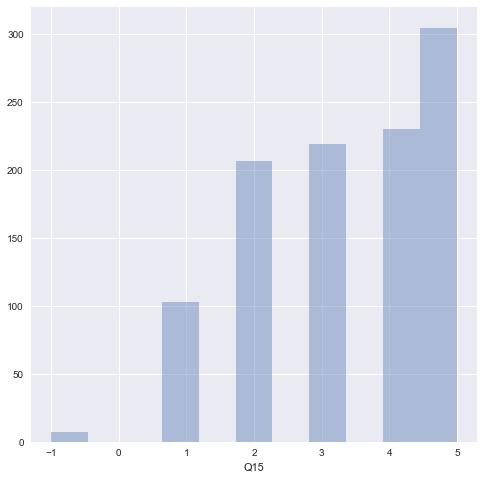

In [9]:
sns.set(rc={"figure.figsize": (8, 8)})
sns.distplot(hsq.Q15, kde=False)

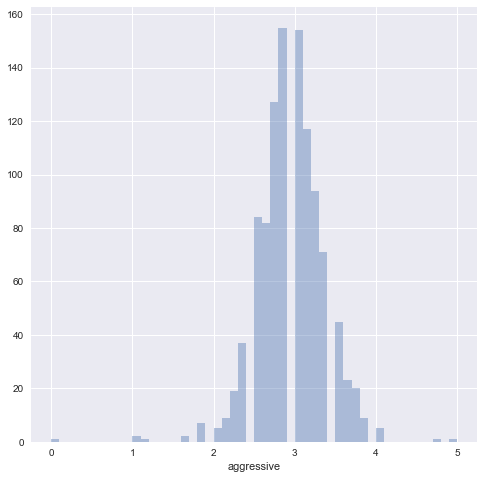

In [10]:
sns.distplot(hsq.aggressive, kde=False)

**C.4.7** Based on the plots it looks like the calculation of the aggressive style lowers the variability, based on the "tighter" distribution. Then again, the question distribution is far from a normal distribution, and so the standard deviation measure is not that descriptive.

---

## D: Convert the data from "wide" to "long"

### D.1: Make the question columns clearer

**D.1.1** Before we transform our DataFrame to long format, we should make the questions more descriptive so that we know what they are referring to. Use the provided dictionary of question numbers and names to transform the column labels.

In [1]:
column_change = {
    'Q1':'usually_dont_laugh',
    'Q2':'if_depressed_use_humor',
    'Q3':'tease_others_mistakes',
    'Q4':'let_others_laugh_at_me',
    'Q5':'make_others_laugh_easy',
    'Q6':'when_alone_amused',
    'Q7':'my_humor_never_offensive',
    'Q8':'use_self_deprecation',
    'Q9':'rarely_make_laugh_stories',
    'Q10':'if_upset_use_humor',
    'Q11':'dont_care_impact_jokes',
    'Q12':'self_deprecate_to_befriend',
    'Q13':'laugh_alot_with_friends',
    'Q14':'humorous_outlook_improves_mood',
    'Q15':'dislike_mean_humor',
    'Q16':'dont_self_deprecate',
    'Q17':'dont_like_telling_jokes',
    'Q18':'when_alone_try_laugh',
    'Q19':'joke_when_inappropriate',
    'Q20':'harshly_self_deprecate',
    'Q21':'enjoy_making_others_laugh',
    'Q22':'if_sad_cant_laugh',
    'Q23':'never_use_mean_humor',
    'Q24':'friends_often_tease_me',
    'Q25':'dont_often_joke',
    'Q26':'humor_coping_mechanism',
    'Q27':'tease_disliked_people',
    'Q28':'hide_unhappiness_humor',
    'Q29':'cant_think_witty_things',
    'Q30':'dont_need_others_amused',
    'Q31':'if_mean_wont_laugh',
    'Q32':'allow_others_tease_me'
}

In [12]:
hsq.rename(columns=column_change, inplace=True)

**D.1.2** Print out the columns and take a look at the header to make sure the columns were renamed.

In [13]:
print(hsq.columns)

Index([u'usually_dont_laugh', u'if_depressed_use_humor',
       u'tease_others_mistakes', u'let_others_laugh_at_me',
       u'make_others_laugh_easy', u'when_alone_amused',
       u'my_humor_never_offensive', u'use_self_deprecation',
       u'rarely_make_laugh_stories', u'if_upset_use_humor',
       u'dont_care_impact_jokes', u'self_deprecate_to_befriend',
       u'laugh_alot_with_friends', u'humorous_outlook_improves_mood',
       u'dislike_mean_humor', u'dont_self_deprecate',
       u'dont_like_telling_jokes', u'when_alone_try_laugh',
       u'joke_when_inappropriate', u'harshly_self_deprecate',
       u'enjoy_making_others_laugh', u'if_sad_cant_laugh',
       u'never_use_mean_humor', u'friends_often_tease_me', u'dont_often_joke',
       u'humor_coping_mechanism', u'tease_disliked_people',
       u'hide_unhappiness_humor', u'cant_think_witty_things',
       u'dont_need_others_amused', u'if_mean_wont_laugh',
       u'allow_others_tease_me', u'affiliative', u'selfenhancing',
       u'a

In [14]:
hsq.head()

,usually_dont_laugh,if_depressed_use_humor,tease_others_mistakes,let_others_laugh_at_me,make_others_laugh_easy,when_alone_amused,my_humor_never_offensive,use_self_deprecation,rarely_make_laugh_stories,if_upset_use_humor,...,dont_need_others_amused,if_mean_wont_laugh,allow_others_tease_me,affiliative,selfenhancing,aggressive,selfdefeating,age,gender,accuracy
0,2,2,3,1,4,5,4,3,4,3,...,4,2,2,4.0,3.5,3.0,2.3,25,2,100
1,2,3,2,2,4,4,4,3,4,3,...,4,3,1,3.3,3.5,3.3,2.4,44,2,90
2,3,4,3,3,4,4,3,1,2,4,...,5,4,2,3.9,3.9,3.1,2.3,50,1,75
3,3,3,3,4,3,5,4,3,-1,4,...,5,3,3,3.6,4.0,2.9,3.3,30,2,85
4,1,4,2,2,3,5,4,1,4,4,...,5,4,2,4.1,4.1,2.9,2.0,52,1,80


---

### D.2: Add a subject ID column

We have an index which identifies the rows, but we are going to want a column that is the ID for each subject so that we can keep track of which rows correspond to which subject.

If this is not clear, don't worry. The reason we are doing this will become clear when we look at the long-form data visually.

**D.2.1** Create an "ID" array that is the length of the rows in our data and where each element is unique.

[NOTE: Don't call this variable "id", as this is reserved. In jupyter notebook, when a variable you are typing gets colored green, you should make it a different name as that is a reserved name.]

In [15]:
subject_ids = np.arange(1, hsq.shape[0]+1)
print subject_ids.shape, hsq.shape
print(subject_ids[0:10])

(1071,) (1071, 39)
[ 1  2  3  4  5  6  7  8  9 10]


**D.2.2** Add a new column to your dataset that is the values of this subject_ids array called "subject_id".

In [16]:
hsq['subject_id'] = subject_ids

---

### D.3: Transform the data to long format

We are now going to transform our dataset from **wide** to **long** format.

The pandas function to convert a wide dataset to a long dataset is **```pd.melt()```**

Here is an example call of the function for a made-up dataset:

```python
id_theft_long = pd.melt(id_theft_wide,
                        id_vars=['full_name','birth_date'],
                        value_vars=['ccv','zip_code','credit_card_number','pin','ssn'],
                        var_name='personal_info',
                        value_name='info_value')
```

So, what are the inputs to this function?

- **```id_theft_wide```:** this is my wide format dataset with peoples personal info.
- **```id_vars```:** these are the columns that are _already identifiers_ or can otherwise not be in value_vars because it is a different data type.
- **```value_vars```:** these are the columns that are going to be now represented in a single value column.
- **```var_name```:** this is the name of the new, single column that will have the identifiers for each value by row. _The value_var columns are now represented in a single column._
- **```value_name```:** this is the name of the new, single column that has the values from the value_vars columns.

**D.3.1** Convert your dataset to long format assigned to a new DataFrame.

- Your id_vars will be:
    - subject_id
    - age
    - gender
- Your ```value_vars``` will be the names of your question, accuracy, and four humor styles columns.
- Make ```var_name``` "variable"
- Make ```value_name``` "value"


In [17]:
style_columns = ['affiliative','selfenhancing','aggressive','selfdefeating']
question_columns = column_change.values()
to_value_variable_columns = style_columns + question_columns + ['accuracy']

id_columns = ['subject_id','age','gender']

hsq_long = pd.melt(hsq, id_vars=id_columns, value_vars=to_value_variable_columns,
                   var_name='variable', value_name='value')

**D.3.2** Look at the header. Print the shape of the long DataFrame as well as the unique values in the "variable" column.

In [18]:
hsq_long.head()

,subject_id,age,gender,variable,value
0,1,25,2,affiliative,4.0
1,2,44,2,affiliative,3.3
2,3,50,1,affiliative,3.9
3,4,30,2,affiliative,3.6
4,5,52,1,affiliative,4.1


In [19]:
print 'Shape:', hsq_long.head()
print 'Unique variable values:', hsq_long.variable.unique()

Shape:    subject_id  age  gender     variable  value
0           1   25       2  affiliative    4.0
1           2   44       2  affiliative    3.3
2           3   50       1  affiliative    3.9
3           4   30       2  affiliative    3.6
4           5   52       1  affiliative    4.1
Unique variable values: ['affiliative' 'selfenhancing' 'aggressive' 'selfdefeating'
 'usually_dont_laugh' 'humor_coping_mechanism' 'tease_others_mistakes'
 'if_depressed_use_humor' 'make_others_laugh_easy' 'let_others_laugh_at_me'
 'my_humor_never_offensive' 'when_alone_amused' 'rarely_make_laugh_stories'
 'use_self_deprecation' 'tease_disliked_people' 'dont_need_others_amused'
 'cant_think_witty_things' 'allow_others_tease_me' 'harshly_self_deprecate'
 'dont_often_joke' 'if_mean_wont_laugh' 'enjoy_making_others_laugh'
 'if_sad_cant_laugh' 'dislike_mean_humor' 'humorous_outlook_improves_mood'
 'dont_like_telling_jokes' 'dont_self_deprecate' 'dont_care_impact_jokes'
 'if_upset_use_humor' 'laugh_alot_wit

**D.3.3** Print the entire subset of the DataFrame where ```subject_id == 10```

In [20]:
print hsq_long[hsq_long.subject_id == 10]

       subject_id  age  gender                        variable  value
9              10   18       1                     affiliative    2.4
1080           10   18       1                   selfenhancing    2.9
2151           10   18       1                      aggressive    3.8
3222           10   18       1                   selfdefeating    2.3
4293           10   18       1              usually_dont_laugh    4.0
5364           10   18       1          humor_coping_mechanism    5.0
6435           10   18       1           tease_others_mistakes    4.0
7506           10   18       1          if_depressed_use_humor    2.0
8577           10   18       1          make_others_laugh_easy    3.0
9648           10   18       1          let_others_laugh_at_me    1.0
10719          10   18       1        my_humor_never_offensive    4.0
11790          10   18       1               when_alone_amused    5.0
12861          10   18       1       rarely_make_laugh_stories    3.0
13932          10   

**D.3.4**
Why is the row index for the subset increasing, but there is such a big difference between them for subject 10?

The ```melt()``` function is not putting the long DataFrame in order of subject_id. It is ordering the DataFrame first by one of the other variables. Because of that, the different rows that correspond to subject 10 are spread out across the DataFrame.

This is why it is important to add the "subject_id" column prior to converting to long format and use it as an id column. Without it we would not know which rows corresponded to which subjects after converting to long format.

**D.3.5** Figure out a way to have the index ordered by subject_id. Google it if you need to. Reset the index of the sorted dataframe and drop the old index with `drop=True`.

In [21]:
hsq_long.sort_values('subject_id', inplace=True)
hsq_long.head()

,subject_id,age,gender,variable,value
0,1,25,2,affiliative,4.0
25704,1,25,2,humorous_outlook_improves_mood,4.0
13923,1,25,2,use_self_deprecation,3.0
18207,1,25,2,allow_others_tease_me,2.0
21420,1,25,2,if_mean_wont_laugh,2.0


In [22]:
hsq_long.reset_index(drop=True, inplace=True)
hsq_long.head()

,subject_id,age,gender,variable,value
0,1,25,2,affiliative,4.0
1,1,25,2,humorous_outlook_improves_mood,4.0
2,1,25,2,use_self_deprecation,3.0
3,1,25,2,allow_others_tease_me,2.0
4,1,25,2,if_mean_wont_laugh,2.0


---

## E: Clean dataset and transform variables

Transformation and manipulation of variables within subsets of your data is an essential data science skill!

Cleaning is also essential. Cleaning data means removing "bad" data or any data that should be excluded from your analyses.

### E.1: Convert the gender column to a string representation

Recall that:
    
    1 == 'male'
    2 == 'female'
    3 == 'other'

Let's make gender more readable. Convert the numeric gender column to a string column with the gender labels.

In [23]:
def convert_gender(x):
    if x == 1:
        return 'male'
    elif x == 2:
        return 'female'
    elif x == 3:
        return 'other'

In [24]:
hsq_long['gender'] = hsq_long.gender.map(convert_gender)

In [25]:
hsq_long.head()

,subject_id,age,gender,variable,value
0,1,25,female,affiliative,4.0
1,1,25,female,humorous_outlook_improves_mood,4.0
2,1,25,female,use_self_deprecation,3.0
3,1,25,female,allow_others_tease_me,2.0
4,1,25,female,if_mean_wont_laugh,2.0


---

### E.2: Removing subjects from the dataset

**E.2.1** Users that did not respond to certain questions are going to have potentially unreasonable values for their humor style ratings. 

Find the users that responded ```-1``` on any of the questions.

In [26]:
unresponded = hsq_long[hsq_long.value == -1]
print(unresponded.shape)

(162, 5)


In [27]:
incomplete_subs = unresponded.subject_id.value_counts()
print incomplete_subs.shape
print incomplete_subs

(78,)
1026    32
716     19
814     15
502     13
898      4
46       2
536      2
895      2
788      2
807      2
482      2
774      1
86       1
552      1
591      1
858      1
1048     1
605      1
351      1
60       1
56       1
1044     1
355      1
505      1
26       1
290      1
1053     1
108      1
634      1
535      1
        ..
452      1
466      1
724      1
984      1
731      1
222      1
491      1
237      1
1010     1
499      1
501      1
190      1
955      1
697      1
656      1
759      1
122      1
771      1
639      1
647      1
649      1
150      1
694      1
165      1
682      1
684      1
980      1
179      1
436      1
1005     1
Name: subject_id, dtype: int64


In [28]:
bad_subjects = incomplete_subs.index.values
print bad_subjects

[1026  716  814  502  898   46  536  895  788  807  482  774   86  552  591
  858 1048  605  351   60   56 1044  355  505   26  290 1053  108  634  535
  530  529  527 1038   13  779  265  262    4  316  612  376  879  118  959
  448  705  450  452  466  724  984  731  222  491  237 1010  499  501  190
  955  697  656  759  122  771  639  647  649  150  694  165  682  684  980
  179  436 1005]


**E.2.2** Remove all rows from the datasets corresponding to the bad users.

HINTS:
    
- The **```~```** operator can invert a logical condition/boolean array.
- The **```.isin()```** built-in function takes a list of values and returns a boolean array that indicates whether any of the Series or DataFrame values were a member of the list.
    

In [29]:
print hsq_long.shape

hsq_long = hsq_long[~hsq_long.subject_id.isin(bad_subjects)]

print hsq_long.shape

(39627, 5)
(36741, 5)


**E.2.3** Subjects who entered 0 for accuracy are actually requesting to not be part of the research. Respecting their wishes, check if any subjects entered 0 for accuracy and remove them.

In [30]:
request_exclusion = hsq_long[(hsq_long.variable == 'accuracy') & (hsq_long.value == 0)]
print request_exclusion.shape

(0, 5)


**E.2.4** Find the subjects that reported an age over 100 and remove them, because they're lying.

In [31]:
lying_subjects = hsq_long[hsq_long.age > 100]
lying_subjects = np.unique(lying_subjects.subject_id.values)
print lying_subjects, lying_subjects.shape

[294 304 633 958] (4,)


In [32]:
hsq_long = hsq_long[~hsq_long.subject_id.isin(lying_subjects)]
print hsq_long.shape

(36593, 5)


---

### E.3: Transform variables (invert some)

Some of the scales need to be reversed. We will transform variables so that the valence of the 1-5 likert scale is always going from negative valence to positive valence.

For example the scale for this question is already correctly rated from 1 to 5:

    Even if I'm by myself, I'm often amused by the absurdity of life.
    
And this is one that needs to be reversed, since the 1 value actually corresponds to a positive humor style:

    I usually don't laugh or joke around much with other people.
    
Below is a list of the questions that need to be inverted.

In [33]:
inverted_questions = ['usually_dont_laugh',
                      'tease_others_mistakes',
                      'let_others_laugh_at_me',
                      'rarely_make_laugh_stories',
                      'use_self_deprecation',
                      'tease_disliked_people',
                      'cant_think_witty_things',
                      'allow_others_tease_me',
                      'harshly_self_deprecate',
                      'dont_often_joke',
                      'if_sad_cant_laugh',
                      'dont_like_telling_jokes',
                      'dont_care_impact_jokes',
                      'self_deprecate_to_befriend',
                      'friends_often_tease_me',
                      'joke_when_inappropriate']

**E.3.1** Write a function that will accept a score value and "invert" the score. That is to say:

    1 -> 5
    2 -> 4
    3 -> 3
    4 -> 2
    5 -> 1

In [34]:
def score_inverter(question_score):
    if question_score == 5:
        return 1
    elif question_score == 4:
        return 2
    elif question_score == 3:
        return 3
    elif question_score == 2:
        return 4
    elif question_score == 1:
        return 5
    

**E.3.2** Apply the score inverter function to the values where the variable is in the ```inverted_question``` list, reassigning the ```value``` column at those locations.

Don't forget about the ```.isin()``` function for Series as well as the ```.map()``` or ```.apply()``` functions for element-wise operations on a Series!

http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.isin.html

http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html

http://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.Series.apply.html

In [35]:
row_mask = hsq_long.variable.isin(inverted_questions)
print row_mask[0:10]

hsq_long.ix[row_mask, 'value'] = hsq_long.value[row_mask].apply(score_inverter)

0    False
1    False
2     True
3     True
4    False
5     True
6    False
7    False
8     True
9    False
Name: variable, dtype: bool


---

## F: Transforming the dataset back to wide format

Now we will transform the DataFrame in long format back to wide format.

We are going to be using the powerful **```pd.pivot_table()```** function. 

---

### F.1: Use pd.pivot_table() to re-widen your data

The ```pd.pivot_table()``` function takes a variety of arguments. For now, lets just set the keyword arguments and corresponding values outlined below:

- **data** The first argument is your DataFrame you are going to pivot.

- **index** is the key or keys to group by along the pivot table indices, or rows. These "keys" are column names in your DataFrame:

```python
index = ['subject_id','age','gender']
```

- **columns** is the key or keys to group by along the pivot table columns. These are also column names or a name:

```python
columns = ['variable']
```

- **values** is the key or keys that are the values to "aggregate". More on aggregation soon, but don't worry about it right now.

```python
values = 'value'
```

- **aggfunc** should be the count, which can be the function `len`

```python
aggfunc = len
```

**F.1.1** Create a new widened DataFrame from your long data using the specified keyword arguments above. Print out the head and the shape as well.

In [36]:
hsq_wide = pd.pivot_table(hsq_long,
                          index=['gender'],
                          columns=['variable'],
                          values='value',
                          aggfunc=len)

In [37]:
hsq_wide

variable,accuracy,affiliative,aggressive,allow_others_tease_me,cant_think_witty_things,dislike_mean_humor,dont_care_impact_jokes,dont_like_telling_jokes,dont_need_others_amused,dont_often_joke,...,rarely_make_laugh_stories,self_deprecate_to_befriend,selfdefeating,selfenhancing,tease_disliked_people,tease_others_mistakes,use_self_deprecation,usually_dont_laugh,when_alone_amused,when_alone_try_laugh
gender,,,,,,,,,,,,,,,,,,,,,
female,442.0,442.0,442.0,442.0,442.0,442.0,442.0,442.0,442.0,442.0,...,442.0,442.0,442.0,442.0,442.0,442.0,442.0,442.0,442.0,442.0
male,535.0,535.0,535.0,535.0,535.0,535.0,535.0,535.0,535.0,535.0,...,535.0,535.0,535.0,535.0,535.0,535.0,535.0,535.0,535.0,535.0
other,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,...,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0


#### F.1.2 Reset the index and turn the data into long format

The long form melted dataset should have 3 columns: gender, variable, and count.

In [38]:
hsq_count_long = hsq_wide.reset_index()

hsq_count_long = pd.melt(hsq_count_long, id_vars='gender',
                      value_name='count')

hsq_count_long.head()

,gender,variable,count
0,female,accuracy,442.0
1,male,accuracy,535.0
2,other,accuracy,8.0
3,female,affiliative,442.0
4,male,affiliative,535.0


#### F.1.3 Merge the count long dataset into the full long dataset

Merge this small counts by gender and variable dataframe with the original full long dataframe.

You have two key variables in the counts dataframe that we need to match with in the full long dataframe.

Your code would look something like this:

```python
hsq_long_merged = hsq_long.merge(hsq_count_long, on=['gender','variable'])
```

In [39]:
hsq_long_merged = hsq_long.merge(hsq_count_long, on=['gender','variable'])

In [40]:
hsq_long_merged.head()

,subject_id,age,gender,variable,value,count
0,1,25,female,affiliative,4.0,442.0
1,2,44,female,affiliative,3.3,442.0
2,6,30,female,affiliative,3.6,442.0
3,9,30,female,affiliative,4.1,442.0
4,17,27,female,affiliative,5.0,442.0


#### F.1.4 Use the pivot table function to calculate the mean of both the original values and the counts by gender and age across variables

Example code could be something like this:

```python
value_count_means = pd.pivot_table(hsq_long_merged,
                                   index=['gender','age'],
                                   columns=['variable'],
                                   values=['value', 'count'],
                                   aggfunc=np.mean)
```

In [41]:
value_count_means = pd.pivot_table(hsq_long_merged,
                                   index=['gender','age'],
                                   columns=['variable'],
                                   values=['value', 'count'],
                                   aggfunc=np.mean)

In [42]:
value_count_means.head(3)

value                                               \
variable     accuracy affiliative aggressive allow_others_tease_me   
gender age                                                           
female 14   86.818182    4.263636   3.154545              3.636364   
       15   88.842105    3.915789   3.136842              3.789474   
       16   86.419355    4.032258   2.996774              3.354839   

                                                                              \
variable   cant_think_witty_things dislike_mean_humor dont_care_impact_jokes   
gender age                                                                     
female 14                 3.727273           3.272727               3.090909   
       15                 3.684211           3.315789               2.947368   
       16                 3.903226           3.580645               3.451613   

                                                                            \
variable   dont_like_telling_jokes dont_need_others_amused dont_often_joke   
gender age                                                                   
female 14                 4.363636                4.363636        4.909091   
       15                 3.789474                4.105263        4.157895   
       16                 4.064516                4.096774        4.580645   

                   ...                              count  \
variable           ...          rarely_make_laugh_stories   
gender age         ...                                      
female 14          ...                              442.0   
       15          ...                              442.0   
       16          ...                              442.0   

                                                                   \
variable   self_deprecate_to_befriend selfdefeating selfenhancing   
gender age                                                          
female 14                       442.0         442.0         442.0   
       15                       442.0         442.0         442.0   
       16                       442.0         442.0         442.0   

                                                                             \
variable   tease_disliked_people tease_others_mistakes use_self_deprecation   
gender age                                                                    
female 14                  442.0                 442.0                442.0   
       15                  442.0                 442.0                442.0   
       16                  442.0                 442.0                442.0   

                                                                      
variable   usually_dont_laugh when_alone_amused when_alone_try_laugh  
gender age                                                            
female 14               442.0             442.0                442.0  
       15               442.0             442.0                442.0  
       16               442.0             442.0                442.0  

[3 rows x 74 columns]

---

### F.2: Understanding the MultiIndex

The MultiIndex at first appears daunting and confusing. What is it? How do we use it?

**F.2.1** Print out the columns of your wide value and counts means dataframe you created in the question prior.

In [43]:
value_count_means.columns

MultiIndex(levels=[[u'value', u'count'], [u'accuracy', u'affiliative', u'aggressive', u'allow_others_tease_me', u'cant_think_witty_things', u'dislike_mean_humor', u'dont_care_impact_jokes', u'dont_like_telling_jokes', u'dont_need_others_amused', u'dont_often_joke', u'dont_self_deprecate', u'enjoy_making_others_laugh', u'friends_often_tease_me', u'harshly_self_deprecate', u'hide_unhappiness_humor', u'humor_coping_mechanism', u'humorous_outlook_improves_mood', u'if_depressed_use_humor', u'if_mean_wont_laugh', u'if_sad_cant_laugh', u'if_upset_use_humor', u'joke_when_inappropriate', u'laugh_alot_with_friends', u'let_others_laugh_at_me', u'make_others_laugh_easy', u'my_humor_never_offensive', u'never_use_mean_humor', u'rarely_make_laugh_stories', u'self_deprecate_to_befriend', u'selfdefeating', u'selfenhancing', u'tease_disliked_people', u'tease_others_mistakes', u'use_self_deprecation', u'usually_dont_laugh', u'when_alone_amused', u'when_alone_try_laugh']],
           labels=[[0, 0, 0, 0, 

The columns before was just a list of the column names, but now there are three attributes:

- **levels** is the list of lists that contains the hierarchy of header labels
- **labels** is the list of lists that specifies which level label goes in which position at each hierarchical level
- **names** are the names of the hierarchical header levels

**F.2.2** Print out the ```.columns.names``` property specifically

In [44]:
value_count_means.columns.names

FrozenList([None, u'variable'])

The name for the second level is "variable", and the first (top) level has ```None```: no name.

Why is the top level ```None```? 

The name "variable" is indicating the category, so to speak, of the bottom level header labels. Looking at the ```.head()``` printout, you can see that the "variable" is just to the left of all the bottom level headers. The **name of that level is "variable"** (which is the column they were pulled out of in the long data).

The upper level, "value", has no name because there aren't tiers above it and pandas chooses to not give it a name! 

The names are just convenience anyway, since you **index by labels**.

---

Still confused? Think of it this way: the "value" label at the top spans all the columns and corresponds to the values in the cells of the columns. 

Remember how the variable and value columns in the long data looked?

```
variable       value
--------       -----
accuracy       100
accuracy       80
selfdefeating  2.2
selfenhancing  3.1
selfdefeating  1.1
...
```

**"value" is the top level in the header hierarchy because the unique "variable" column items correspond to a subset of the "value" column numbers.**

---

**F.2.3** Print out the ```.index.names``` property of your wide data

In [45]:
value_count_means.index.names

FrozenList([u'gender', u'age'])

We see that there is `gender` and `age`. These corresponds to the leftmost part of the ```.head()``` printout, which are the row indices (also hierarchical in this case). 

---

### F.3: Indexing with a MultiIndex: alternative methods

pandas provides many different ways you can index your DataFrame when it has a MultiIndex. I am just going to go over three, which are the ones I find most intuitive in order:

1. Using **```.xs()```** which is the "cross-section" indexing function
2. Using a **```pd.IndexSlice```** object
3. Using the **```.query()```** function

Let's start with the cross-section function.

**F.3.1** Type the following (replacing value_count_means with your wide DataFrame name):

```python
value_count_means.xs(3, level='gender')
```

In [46]:
value_count_means.xs(20, level='age')

value                                               \
variable   accuracy affiliative aggressive allow_others_tease_me   
gender                                                             
female    84.076923    3.646154   2.953846              3.269231   
male      86.325000    4.115000   2.927500              2.825000   
other     90.000000    3.000000   2.600000              4.000000   

                                                                            \
variable cant_think_witty_things dislike_mean_humor dont_care_impact_jokes   
gender                                                                       
female                  3.192308           3.576923               3.346154   
male                    3.750000           2.875000               3.350000   
other                   1.000000           3.000000               4.000000   

                                                                          \
variable dont_like_telling_jokes dont_need_others_amused dont_often_joke   
gender                                                                     
female                  3.730769                4.038462        4.076923   
male                    4.325000                4.100000        4.525000   
other                   1.000000                4.000000        5.000000   

                 ...                              count  \
variable         ...          rarely_make_laugh_stories   
gender           ...                                      
female           ...                              442.0   
male             ...                              535.0   
other            ...                                8.0   

                                                                 \
variable self_deprecate_to_befriend selfdefeating selfenhancing   
gender                                                            
female                        442.0         442.0         442.0   
male                          535.0         535.0         535.0   
other                           8.0           8.0           8.0   

                                                                           \
variable tease_disliked_people tease_others_mistakes use_self_deprecation   
gender                                                                      
female                   442.0                 442.0                442.0   
male                     535.0                 535.0                535.0   
other                      8.0                   8.0                  8.0   

                                                                    
variable usually_dont_laugh when_alone_amused when_alone_try_laugh  
gender                                                              
female                442.0             442.0                442.0  
male                  535.0             535.0                535.0  
other                   8.0               8.0                  8.0  

[3 rows x 74 columns]

**F.3.2** the .xs() function is pulling out value 20 at the index level age. So, it is subsetting the data to be everything that corresponds to age == 20.

**F.3.3** 

First remove the `value` column index, making the columns non-hierarchical.

Then type the following python and explain what is happening and why:

```python
value_count_means.xs((21, 'male'), level='age', axis=0, drop_level=False)[['aggressive','affiliative']]
```

In [47]:
value_count_means = value_count_means['value']

In [48]:
value_count_means.xs((21, 'male'), level=('age','gender'), axis=0, drop_level=False)[['aggressive','affiliative']]

,variable,aggressive,affiliative
gender,age,,
male,21,2.904545,3.736364


**F.3.3** Cross section is pulling out along multiple indices using lists/tuples for the section and levels argument. The axis=0 part is saying run this on the row indices (axis=1 would mean your parameters are referring to column indices). drop_levels=False is keeping the indices in the return value.

---

**F.3.4** Let's try out the `.query()` function for DataFrames. Query is very nice because it allows us to enter in expressions as strings that are very intuitive.

Try these query examples out below:

```dislike_mean_humor``` scores for males only aged 18, 25, or 30:

```python
value_count_means.query('(gender == male) and (age in [18, 25, 30)')[['dislike_mean_humor']]
```

In [49]:
value_count_means.query('(gender == "male") and (age in [18, 25, 30])')[['dislike_mean_humor']][1:10]

variable    dislike_mean_humor
gender age                    
male   25             2.947368
       30             3.583333

You can get very complicated with the conditionals.

Try a query where where aggressive, affiliative, selfdefeating, and selfenhancing multiplied by each other are less than the subject's age (and subset to those humor descriptor columns too).

```python
value_count_means.query('(aggresive*affiliative*selfenhancing*selfdefeating) > age')[['aggresive','affiliative','selfenhancing','selfdefeating']]
```

In [50]:
value_count_means.query('(aggressive * affiliative * selfenhancing * selfdefeating) < age')[['aggressive','affiliative','selfdefeating','selfenhancing']]

,variable,aggressive,affiliative,selfdefeating,selfenhancing
gender,age,,,,
male,56,2.5,2.8,2.4,3.1
other,30,3.0,2.5,1.6,2.3


---

More on MultiIndex and advanced indexing below. **HIGHLY RECOMMENDED READING!**

http://pandas.pydata.org/pandas-docs/stable/advanced.html

---

### F.4 Flattening a MultiIndex DataFrame

MultiIndex is great and quite powerful, but if you are feeling overwhelmed and want to go back to the standard indexed data, you can.

You can use **```.reset_index()```** and also **`.to_records()`** to get the same eventual result.

Try it out on the wide data below with:

```python
value_count_means.reset_index()
pd.DataFrame(value_count_means.to_records())
```

In [51]:
value_count_means.reset_index().head()

variable,gender,age,accuracy,affiliative,aggressive,allow_others_tease_me,cant_think_witty_things,dislike_mean_humor,dont_care_impact_jokes,dont_like_telling_jokes,...,rarely_make_laugh_stories,self_deprecate_to_befriend,selfdefeating,selfenhancing,tease_disliked_people,tease_others_mistakes,use_self_deprecation,usually_dont_laugh,when_alone_amused,when_alone_try_laugh
0,female,14,86.818182,4.263636,3.154545,3.636364,3.727273,3.272727,3.090909,4.363636,...,3.181818,3.090909,2.509091,3.509091,3.909091,2.454545,4.181818,4.272727,4.454545,3.181818
1,female,15,88.842105,3.915789,3.136842,3.789474,3.684211,3.315789,2.947368,3.789474,...,3.473684,3.736842,2.652632,3.426316,3.052632,2.421053,3.736842,3.684211,4.263158,2.789474
2,female,16,86.419355,4.032258,2.996774,3.354839,3.903226,3.580645,3.451613,4.064516,...,3.419355,3.354839,2.706452,3.370968,3.870968,2.903226,3.709677,3.967742,4.096774,2.741935
3,female,17,88.551724,3.975862,2.965517,3.034483,3.379310,3.758621,3.172414,3.965517,...,3.482759,2.931034,2.875862,3.268966,3.965517,3.000000,3.448276,4.000000,4.206897,2.137931
4,female,18,86.515152,3.893939,3.066667,3.000000,3.484848,3.424242,3.363636,4.000000,...,3.212121,3.212121,2.887879,3.439394,3.393939,3.000000,3.454545,3.818182,4.181818,2.878788


In [52]:
pd.DataFrame(value_count_means.to_records()).head()

,gender,age,accuracy,affiliative,aggressive,allow_others_tease_me,cant_think_witty_things,dislike_mean_humor,dont_care_impact_jokes,dont_like_telling_jokes,...,rarely_make_laugh_stories,self_deprecate_to_befriend,selfdefeating,selfenhancing,tease_disliked_people,tease_others_mistakes,use_self_deprecation,usually_dont_laugh,when_alone_amused,when_alone_try_laugh
0,female,14,86.818182,4.263636,3.154545,3.636364,3.727273,3.272727,3.090909,4.363636,...,3.181818,3.090909,2.509091,3.509091,3.909091,2.454545,4.181818,4.272727,4.454545,3.181818
1,female,15,88.842105,3.915789,3.136842,3.789474,3.684211,3.315789,2.947368,3.789474,...,3.473684,3.736842,2.652632,3.426316,3.052632,2.421053,3.736842,3.684211,4.263158,2.789474
2,female,16,86.419355,4.032258,2.996774,3.354839,3.903226,3.580645,3.451613,4.064516,...,3.419355,3.354839,2.706452,3.370968,3.870968,2.903226,3.709677,3.967742,4.096774,2.741935
3,female,17,88.551724,3.975862,2.965517,3.034483,3.379310,3.758621,3.172414,3.965517,...,3.482759,2.931034,2.875862,3.268966,3.965517,3.000000,3.448276,4.000000,4.206897,2.137931
4,female,18,86.515152,3.893939,3.066667,3.000000,3.484848,3.424242,3.363636,4.000000,...,3.212121,3.212121,2.887879,3.439394,3.393939,3.000000,3.454545,3.818182,4.181818,2.878788


In the case of reset_index, your index is now called "variable". with to_records(), the index is just the standard integer labels for rows. All the hierarchical indices have been flattened down into columns.

check out the ```.columns```